In [1]:
!pip install control

Defaulting to user installation because normal site-packages is not writeable


## 1. Implementación para Control de Velocidad

## 1.1 Modelo en Espacio de Estados

In [12]:
import numpy as np
import control as ctrl

# Parámetros identificados
K = 2084.9898
wn = 35.3737
zeta = 0.7204

# Matrices del sistema para velocidad
A_vel = np.array([[0, 1],
                 [-wn**2, -2*zeta*wn]])
B_vel = np.array([[0],
                 [K * wn**2]])
C_vel = np.array([[1, 0]])  # Salida = velocidad
D_vel = np.array([[0]])

# Crear el sistema
sys_vel = ctrl.ss(A_vel, B_vel, C_vel, D_vel)

## 1.2 Diseño del Controlador

In [11]:
# Polos deseados (según especificaciones: ts=0.4s, Mp<10%)
polo_deseado_vel = [-10 + 13.64j, -10 - 13.64j]

# Cálculo de la ganancia K por colocación de polos
K_vel = ctrl.place(A_vel, B_vel, polo_deseado_vel)
print("Ganancia de realimentación para velocidad:")
print(K_vel)

# Precompensación N_bar para seguimiento de referencia
N_bar_vel = -1.0 / (C_vel @ np.linalg.inv(A_vel - B_vel @ K_vel) @ B_vel)
B_vel_scaled = B_vel * N_bar_vel

Ganancia de realimentación para velocidad:
[[-3.69976783e-04 -1.18693295e-05]]


## 1.3 Sistema en Lazo Cerrado

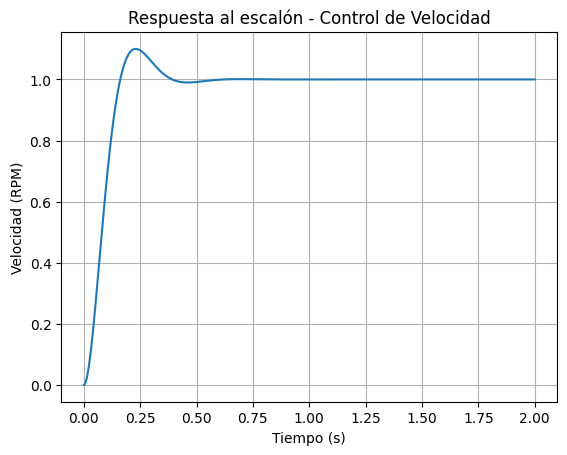

In [10]:
# Sistema en lazo cerrado
A_cl_vel = A_vel - B_vel @ K_vel
sys_cl_vel = ctrl.ss(A_cl_vel, B_vel_scaled, C_vel, D_vel)

# Simulación
t_vel = np.linspace(0, 2, 500)
t_out_vel, y_out_vel = ctrl.step_response(sys_cl_vel, T=t_vel)

# Gráfico
import matplotlib.pyplot as plt
plt.plot(t_out_vel, y_out_vel)
plt.title("Respuesta al escalón - Control de Velocidad")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (RPM)")
plt.grid(True)
plt.show()

## 2. Implementación para Control de Posición

## 2.1 Modelo Extendido en Espacio de Estados

In [5]:
# Matrices del sistema extendido (orden 3 para posición)
A_pos = np.array([[0, 1, 0],
                 [0, 0, 1],
                 [0, -wn**2, -2*zeta*wn]])
B_pos = np.array([[0],
                 [0],
                 [K * wn**2]])
C_pos = np.array([[1, 0, 0]])  # Salida = posición
D_pos = np.array([[0]])

# Crear el sistema
sys_pos = ctrl.ss(A_pos, B_pos, C_pos, D_pos)

## 2.2 Diseño del Controlador

In [14]:
# Polos deseados para posición (más lentos y amortiguados)
polo1_pos = -4 + 5j
polo2_pos = -4 - 5j
polo3_pos = -8  # Polo real adicional
polo_deseado_pos = [polo1_pos, polo2_pos, polo3_pos]

# Cálculo de la ganancia K por colocación de polos
K_pos = ctrl.place(A_pos, B_pos, polo_deseado_pos)
print("Ganancia de realimentación para posición:")
print(K_pos)

# Precompensación N_bar para seguimiento de referencia
N_bar_pos = -1.0 / (C_pos @ np.linalg.inv(A_pos - B_pos @ K_pos) @ B_pos)
B_pos_scaled = B_pos * N_bar_pos
print("Precompensación N_bar para posición:", N_bar_pos)

Ganancia de realimentación para posición:
[[ 1.25721320e-04 -4.39372499e-04 -1.34025163e-05]]
Precompensación N_bar para posición: [[0.00012572]]


## 2.3 Sistema en Lazo Cerrado

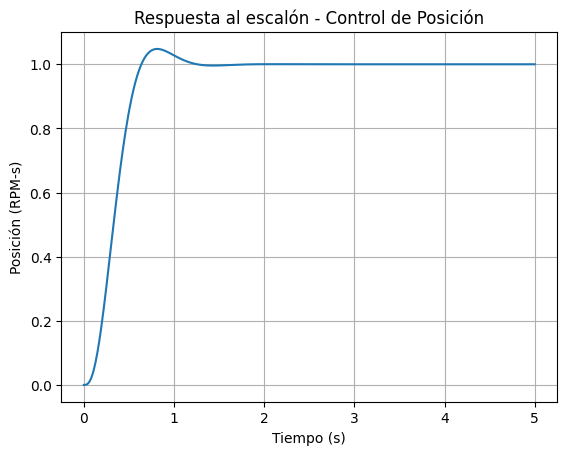

In [7]:
# Sistema en lazo cerrado
A_cl_pos = A_pos - B_pos @ K_pos
sys_cl_pos = ctrl.ss(A_cl_pos, B_pos_scaled, C_pos, D_pos)

# Simulación
t_pos = np.linspace(0, 5, 500)
t_out_pos, y_out_pos = ctrl.step_response(sys_cl_pos, T=t_pos)

# Gráfico
plt.plot(t_out_pos, y_out_pos)
plt.title("Respuesta al escalón - Control de Posición")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (RPM-s)")
plt.grid(True)
plt.show()

## 3. Análisis de Robustez (para ambos casos)

## 3.1 Para Control de Velocidad

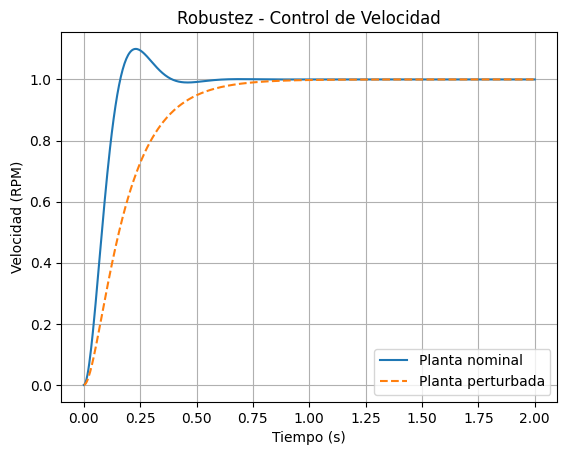

In [8]:
# Planta perturbada (mayor inercia y fricción)
wn_pert = wn * 0.7
zeta_pert = zeta * 1.2

A_vel_pert = np.array([[0, 1],
                      [-wn_pert**2, -2*zeta_pert*wn_pert]])
B_vel_pert = np.array([[0],
                      [K * wn_pert**2]])

# Recalcular N_bar para planta perturbada
N_bar_vel_pert = -1.0 / (C_vel @ np.linalg.inv(A_vel_pert - B_vel_pert @ K_vel) @ B_vel_pert)
B_vel_pert_scaled = B_vel_pert * N_bar_vel_pert

# Sistema perturbado en lazo cerrado
A_cl_vel_pert = A_vel_pert - B_vel_pert @ K_vel
sys_vel_pert = ctrl.ss(A_cl_vel_pert, B_vel_pert_scaled, C_vel, D_vel)

# Simulación comparativa
t_vel_pert, y_vel_pert = ctrl.step_response(sys_vel_pert, T=t_vel)

plt.plot(t_out_vel, y_out_vel, label='Planta nominal')
plt.plot(t_vel_pert, y_vel_pert, '--', label='Planta perturbada')
plt.title("Robustez - Control de Velocidad")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (RPM)")
plt.grid(True)
plt.legend()
plt.show()

## 3.2 Para Control de Posición

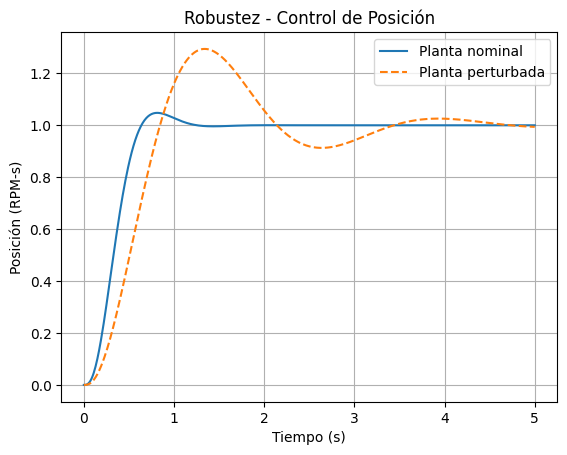

In [9]:
# Planta perturbada para posición
A_pos_pert = np.array([[0, 1, 0],
                      [0, 0, 1],
                      [0, -wn_pert**2, -2*zeta_pert*wn_pert]])
B_pos_pert = np.array([[0],
                      [0],
                      [K * wn_pert**2]])

# Recalcular N_bar para planta perturbada
N_bar_pos_pert = -1.0 / (C_pos @ np.linalg.inv(A_pos_pert - B_pos_pert @ K_pos) @ B_pos_pert)
B_pos_pert_scaled = B_pos_pert * N_bar_pos_pert

# Sistema perturbado en lazo cerrado
A_cl_pos_pert = A_pos_pert - B_pos_pert @ K_pos
sys_pos_pert = ctrl.ss(A_cl_pos_pert, B_pos_pert_scaled, C_pos, D_pos)

# Simulación comparativa
t_pos_pert, y_pos_pert = ctrl.step_response(sys_pos_pert, T=t_pos)

plt.plot(t_out_pos, y_out_pos, label='Planta nominal')
plt.plot(t_pos_pert, y_pos_pert, '--', label='Planta perturbada')
plt.title("Robustez - Control de Posición")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (RPM-s)")
plt.grid(True)
plt.legend()
plt.show()